In [1]:
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import wbdata
import numpy as np
import math
import collections

In [22]:
data=pd.read_excel("WDI_excel/WDIEXCEL.xlsx",sheet_name='Data')

In [34]:
countries=['GRC','DEU','ITA','FRA'] 

In [29]:
df=data[data['Country Code'].isin(countries)]

Calculate total number of NaNs for each country:

In [30]:
df2=df.set_index('Country Code').isna().sum(level=0)

In [31]:
for code in countries:
    print('Total NaNs for {} : {}'.format(code,df2[df2.index==code].sum(axis=1)[0]))
    print('*'*30)



Total NaNs for GRC : 50714.0
******************************
Total NaNs for DEU : 52461.0
******************************
Total NaNs for ITA : 49877.0
******************************
Total NaNs for FRA : 49439.0
******************************


Find all the distinct indicator codes

In [32]:
indicator_codes=df['Indicator Code'].unique()
print('There are',indicator_codes.shape[0],'distinct indicator codes in the dataset')

There are 1431 distinct indicator codes in the dataset


For each country: for each indicator: find the connectivity up to 1960

In [33]:

def get_max_con_indicators(countries,n):
    '''Get top n indicator codes with max connectivity ''' 
    
    results=pd.DataFrame()

    for country in countries:
        
        connectivity={}

        for code in indicator_codes:

            count=0
            start=False
            
            for row in df[ (df['Country Code']==country) & (df['Indicator Code']==code) ].iterrows():

                for i in range(1,60,1):
                    if not np.isnan(row[1][-i]):
                        count+=1
                        start=True
                    elif ((np.isnan(row[1][-i])) and (start==False)):
                        continue
                    else:
                        break

                connectivity[code]=count       

        connectivity = collections.OrderedDict(sorted(connectivity.items(), key=lambda k: k[1],reverse=True))
        
        results[country]=[list(connectivity.items())[i] for i in range(1,n+1,1)]
        
    return results
    


In [52]:
print('Connectivity of every indicator code')
get_max_con_indicators(countries,10)

Connectivity of every indicator code


,GRC,DEU,ITA,FRA
0,"(SP.POP.DPND.OL, 58)","(SP.POP.DPND.OL, 58)","(SP.POP.DPND.OL, 58)","(SP.POP.DPND.OL, 58)"
1,"(SP.POP.DPND.YG, 58)","(SP.POP.DPND.YG, 58)","(SP.POP.DPND.YG, 58)","(SP.POP.DPND.YG, 58)"
2,"(MS.MIL.MPRT.KD, 58)","(MS.MIL.XPRT.KD, 58)","(MS.MIL.XPRT.KD, 58)","(NV.AGR.TOTL.ZS, 58)"
3,"(FP.CPI.TOTL, 58)","(MS.MIL.MPRT.KD, 58)","(MS.MIL.MPRT.KD, 58)","(NV.AGR.TOTL.KD.ZG, 58)"
4,"(PA.NUS.ATLS, 58)","(FP.CPI.TOTL, 58)","(FP.CPI.TOTL, 58)","(NV.AGR.TOTL.KD, 58)"
5,"(NY.EXP.CAPM.KN, 58)","(PA.NUS.ATLS, 58)","(PA.NUS.ATLS, 58)","(NV.AGR.TOTL.KN, 58)"
6,"(NE.EXP.GNFS.ZS, 58)","(FP.CPI.TOTL.ZG, 58)","(NY.EXP.CAPM.KN, 58)","(NV.AGR.TOTL.CN, 58)"
7,"(NE.EXP.GNFS.KD.ZG, 58)","(AG.LND.TOTL.K2, 58)","(NE.EXP.GNFS.ZS, 58)","(NV.AGR.TOTL.CD, 58)"
8,"(NE.EXP.GNFS.KD, 58)","(TX.VAL.MRCH.CD.WT, 58)","(NE.EXP.GNFS.KD.ZG, 58)","(MS.MIL.XPRT.KD, 58)"
9,"(NE.EXP.GNFS.KN, 58)","(TM.VAL.MRCH.CD.WT, 58)","(NE.EXP.GNFS.KD, 58)","(MS.MIL.MPRT.KD, 58)"


2. -Connect to the World Bank API wbdata,
   -Select some indicator codes, 
   -get the data from the API for the selected countries,
   -calculate correlation between the indicator codes of each country
   

In [36]:
indicators = { 
              "NY.GDY.TOTL.KN":"gross_income", 
              "SP.POP.GROW":"pop_growth_annual",
              "NY.GDP.PCAP.KN": "gdp_per_capita",
              "NE.TRD.GNFS.ZS":"trade_percent",
              "MS.MIL.MPRT.KD":"arms_import",
              "FP.CPI.TOTL":"consumer_price_index",
              "NY.GDP.MKTP.KD.ZG":"gdp_growth",
              "NE.EXP.GNFS.ZS":"export_gdp",
              "NE.RSB.GNFS.CD":"external_bal",
              "MS.MIL.XPND.GD.ZS":"military_exp"
             }

In [37]:
api_data=wbdata.get_dataframe(indicators, country=countries)

In [38]:
api_data=api_data.reset_index()

In [40]:
GRCdata=api_data[api_data['country']=='Greece']
DEUdata=api_data[api_data['country']=='Germany']
ITAdata=api_data[api_data['country']=='Italy']
FRAdata=api_data[api_data['country']=='France']

In [41]:
corrGRC=GRCdata.corr()
corrDEU=DEUdata.corr()
corrITA=ITAdata.corr()
corrFRA=FRAdata.corr()

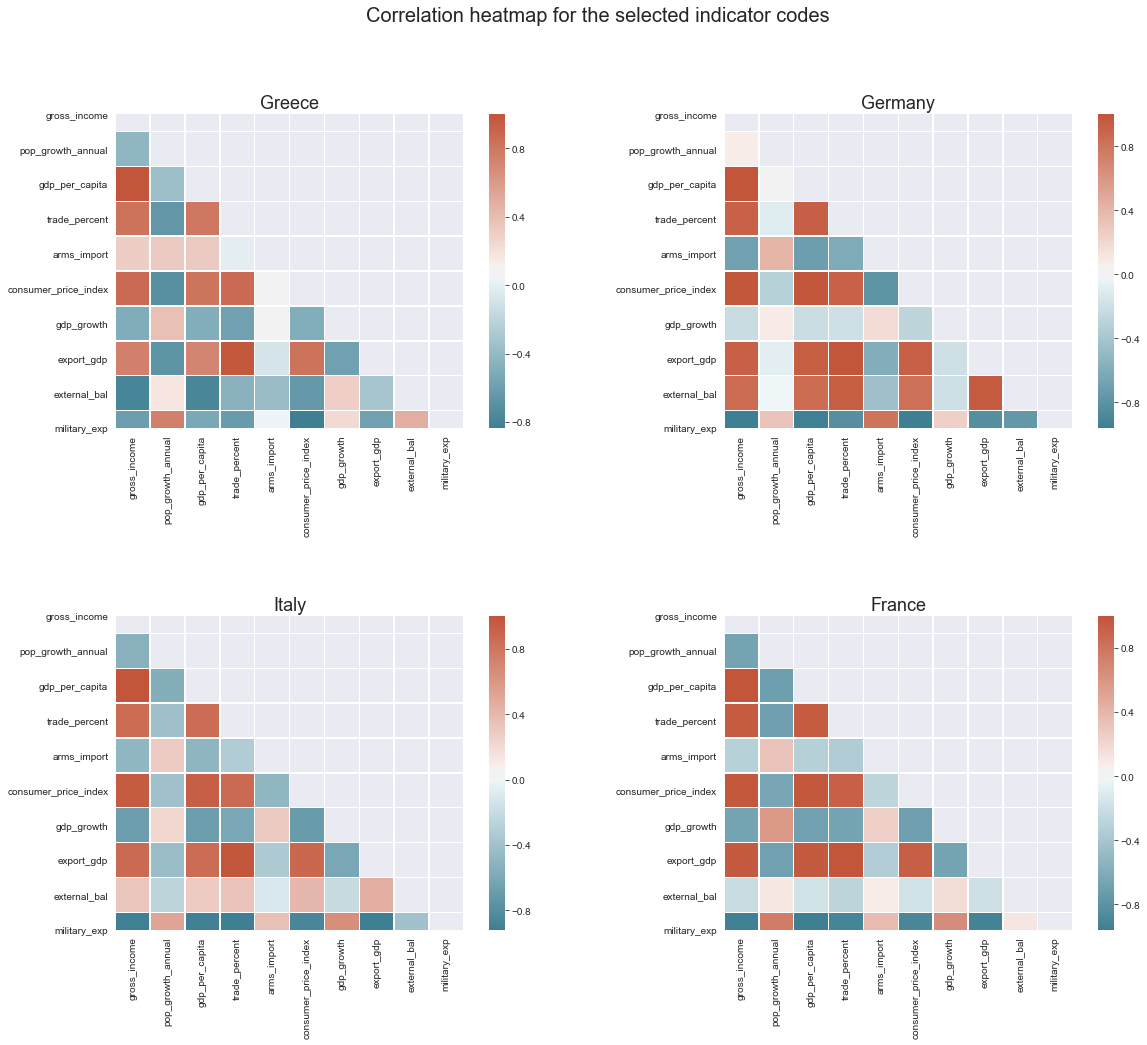

In [42]:
fig, axs = plt.subplots(2,2,figsize=(20, 15))
plt.suptitle('Correlation heatmap for the selected indicator codes',fontsize=20)
mask = np.zeros_like(corrGRC, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(corrGRC, mask=mask, cmap=cmap, linewidths=.5,square=True,ax=axs[0][0])
sns.heatmap(corrDEU, mask=mask, cmap=cmap, linewidths=.5,square=True,ax=axs[0][1])
sns.heatmap(corrITA, mask=mask, cmap=cmap, linewidths=.5,square=True,ax=axs[1][0])
sns.heatmap(corrFRA, mask=mask, cmap=cmap, linewidths=.5,square=True,ax=axs[1][1])

axs[0][0].set_title('Greece',fontsize=18)
axs[0][1].set_title('Germany',fontsize=18)
axs[1][0].set_title('Italy',fontsize=18)
axs[1][1].set_title('France',fontsize=18)

plt.subplots_adjust(hspace=0.6)
plt.show()
    

In [44]:
corrGRC

,gross_income,pop_growth_annual,gdp_per_capita,trade_percent,arms_import,consumer_price_index,gdp_growth,export_gdp,external_bal,military_exp
gross_income,1.000000,-0.426138,0.993276,0.829725,0.312558,0.874384,-0.502057,0.750944,-0.789244,-0.604960
pop_growth_annual,-0.426138,1.000000,-0.363670,-0.649826,0.336701,-0.698249,0.383979,-0.676125,0.175725,0.753163
gdp_per_capita,0.993276,-0.363670,1.000000,0.803362,0.339583,0.820010,-0.492765,0.725756,-0.772019,-0.531694
trade_percent,0.829725,-0.649826,0.803362,1.000000,-0.010139,0.873922,-0.580108,0.982663,-0.461119,-0.622770
arms_import,0.312558,0.336701,0.339583,-0.010139,1.000000,0.097595,0.097292,-0.082048,-0.380556,0.038107
consumer_price_index,0.874384,-0.698249,0.820010,0.873922,0.097595,1.000000,-0.495320,0.830859,-0.639359,-0.835269
gdp_growth,-0.502057,0.383979,-0.492765,-0.580108,0.097292,-0.495320,1.000000,-0.580044,0.305116,0.238574
export_gdp,0.750944,-0.676125,0.725756,0.982663,-0.082048,0.830859,-0.580044,1.000000,-0.316789,-0.580518
external_bal,-0.789244,0.175725,-0.772019,-0.461119,-0.380556,-0.639359,0.305116,-0.316789,1.000000,0.490312
military_exp,-0.604960,0.753163,-0.531694,-0.622770,0.038107,-0.835269,0.238574,-0.580518,0.490312,1.000000


In [45]:
corrDEU

,gross_income,pop_growth_annual,gdp_per_capita,trade_percent,arms_import,consumer_price_index,gdp_growth,export_gdp,external_bal,military_exp
gross_income,1.000000,0.072065,0.996938,0.921663,-0.690776,0.989486,-0.220977,0.930310,0.857556,-0.960002
pop_growth_annual,0.072065,1.000000,0.052711,-0.101484,0.413607,-0.313233,0.082749,-0.079919,-0.018301,0.321828
gdp_per_capita,0.996938,0.052711,1.000000,0.933526,-0.709104,0.993345,-0.209742,0.939014,0.858106,-0.947526
trade_percent,0.921663,-0.101484,0.933526,1.000000,-0.608360,0.921840,-0.186797,0.997955,0.945283,-0.824445
arms_import,-0.690776,0.413607,-0.709104,-0.608360,1.000000,-0.785225,0.177652,-0.590374,-0.441835,0.805069
consumer_price_index,0.989486,-0.313233,0.993345,0.921840,-0.785225,1.000000,-0.278443,0.926203,0.836829,-0.954837
gdp_growth,-0.220977,0.082749,-0.209742,-0.186797,0.177652,-0.278443,1.000000,-0.193149,-0.191435,0.246811
export_gdp,0.930310,-0.079919,0.939014,0.997955,-0.590374,0.926203,-0.193149,1.000000,0.957819,-0.839379
external_bal,0.857556,-0.018301,0.858106,0.945283,-0.441835,0.836829,-0.191435,0.957819,1.000000,-0.757040
military_exp,-0.960002,0.321828,-0.947526,-0.824445,0.805069,-0.954837,0.246811,-0.839379,-0.757040,1.000000


In [46]:
corrITA

,gross_income,pop_growth_annual,gdp_per_capita,trade_percent,arms_import,consumer_price_index,gdp_growth,export_gdp,external_bal,military_exp
gross_income,1.000000,-0.535496,0.997977,0.863675,-0.485360,0.955477,-0.680840,0.870647,0.322750,-0.908242
pop_growth_annual,-0.535496,1.000000,-0.544846,-0.414149,0.288242,-0.407739,0.229410,-0.438590,-0.257929,0.522933
gdp_per_capita,0.997977,-0.544846,1.000000,0.850571,-0.494301,0.939728,-0.672015,0.855062,0.295341,-0.899502
trade_percent,0.863675,-0.414149,0.850571,1.000000,-0.316419,0.867263,-0.599477,0.986483,0.336893,-0.916441
arms_import,-0.485360,0.288242,-0.494301,-0.316419,1.000000,-0.485581,0.302254,-0.334626,-0.104073,0.361499
consumer_price_index,0.955477,-0.407739,0.939728,0.867263,-0.485581,1.000000,-0.688526,0.884306,0.406207,-0.863839
gdp_growth,-0.680840,0.229410,-0.672015,-0.599477,0.302254,-0.688526,1.000000,-0.604388,-0.204518,0.659806
export_gdp,0.870647,-0.438590,0.855062,0.986483,-0.334626,0.884306,-0.604388,1.000000,0.461370,-0.918279
external_bal,0.322750,-0.257929,0.295341,0.336893,-0.104073,0.406207,-0.204518,0.461370,1.000000,-0.396723
military_exp,-0.908242,0.522933,-0.899502,-0.916441,0.361499,-0.863839,0.659806,-0.918279,-0.396723,1.000000


In [47]:
corrFRA

,gross_income,pop_growth_annual,gdp_per_capita,trade_percent,arms_import,consumer_price_index,gdp_growth,export_gdp,external_bal,military_exp
gross_income,1.000000,-0.672279,0.995433,0.959117,-0.313000,0.979552,-0.676512,0.962543,-0.217674,-0.943892
pop_growth_annual,-0.672279,1.000000,-0.700589,-0.695782,0.320305,-0.649010,0.588553,-0.690975,0.098156,0.761043
gdp_per_capita,0.995433,-0.700589,1.000000,0.958779,-0.320231,0.979068,-0.689424,0.964338,-0.172164,-0.959886
trade_percent,0.959117,-0.695782,0.958779,1.000000,-0.339881,0.927261,-0.666617,0.994307,-0.281053,-0.916830
arms_import,-0.313000,0.320305,-0.320231,-0.339881,1.000000,-0.270872,0.246796,-0.337993,0.076366,0.372776
consumer_price_index,0.979552,-0.649010,0.979068,0.927261,-0.270872,1.000000,-0.696297,0.934146,-0.174488,-0.897407
gdp_growth,-0.676512,0.588553,-0.689424,-0.666617,0.246796,-0.696297,1.000000,-0.664874,0.166380,0.662979
export_gdp,0.962543,-0.690975,0.964338,0.994307,-0.337993,0.934146,-0.664874,1.000000,-0.190909,-0.923113
external_bal,-0.217674,0.098156,-0.172164,-0.281053,0.076366,-0.174488,0.166380,-0.190909,1.000000,0.115074
military_exp,-0.943892,0.761043,-0.959886,-0.916830,0.372776,-0.897407,0.662979,-0.923113,0.115074,1.000000
